# Problem Statment

**These is a classification problem** to develop a predictive model that can accurately predict the anti-cancer activity of a set of drug compounds, based on their molecular structures.. The performance of the model will be evaluated using various metrics, including accuracy, precision, recall, and F1 score. </br>


**The input** is a dataset of drug compounds represented by their molecular structures. The dataset consists of around 4,000 drug compounds and their corresponding activity levels, measured using a bioassay..</br>
**The output** the label represent if the chemical compound is positive against non-small cell lung cancer, or negative:
* 1 for possitive
* 0 for negative.</br>

**The goal** is to develop a predictive model that can take in the molecular graph representations of the drug compounds and predict their activity levels against cancer cells. 

**The challenges** 
1. Data sparsity and imbalance: The dataset of drug compounds and their activity levels may be sparse, meaning that there is a limited amount of data available for training and testing the predictive model. Additionally, the dataset may be imbalanced, meaning that there are significantly more compounds of one activity level than the other. This can make it difficult to train a predictive model that is both accurate and generalizes well to new data.

2. Complex molecular structures: Drug compounds can have complex molecular structures that require specialized methods for feature extraction and representation. The molecular structures may also contain noise or errors, which can affect the performance of the predictive model.


**The impact of predictive models for anti-cancer drug activity prediction can be significant in several ways:**
1. Accelerating drug discovery: Predictive models can help identify drug compounds with high activity levels against cancer cells more quickly and efficiently than traditional experimental methods. This can accelerate the drug discovery process and reduce the cost and time required to develop new anti-cancer drugs.

2. Improving drug efficacy and safety: Predictive models can help identify drug compounds with higher efficacy and safety profiles, reducing the risk of adverse side effects and improving patient outcomes.

# Let's Get Started

In [1]:

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline
import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, KFold

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, precision_score, recall_score, f1_score, precision_recall_curve
from tqdm.notebook import tqdm
import os
import math
sns.set()

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from time import time
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [2]:
!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.83.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.


In [3]:
from keras.layers import Embedding

In [4]:

from sklearn.utils import resample 
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam


In [5]:

from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Flatten, Dropout
from tensorflow.keras.layers import GRU, LSTM, Bidirectional

In [6]:

!pip install --quiet tf2_gnn

# https://github.com/microsoft/tf2-gnn
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py

from tf2_gnn.layers.gnn import GNN, GNNInput
from tf2_gnn.layers.message_passing import GNN_Edge_MLP, GNN_FiLM

In [7]:

import warnings
warnings.filterwarnings('ignore')

In [8]:
!pip install --quiet networkx
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import cm

In [9]:
from tf2_gnn.layers.gnn import GNN
from tf2_gnn.layers.gnn import GNNInput
from tf2_gnn.layers.message_passing import MessagePassing

In [10]:
import tensorflow as tf
from tensorflow.math import segment_mean
from tensorflow import keras
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, Dense
from tensorflow.keras.optimizers import Adam

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tf2_gnn.layers.gnn import GNN, GNNInput
# from tf2_gnn.utils.gnn import segment_mean

In [12]:

# some seeting for pandas and hvplot

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

## Read SDF format data (structured-data format)

In [13]:
import numpy as np
from tqdm.notebook import tqdm

def read_sdf(file):
    with open(file, 'r') as rf:
        content = rf.read()
    samples = content.split('$$$$')
    
    def parse_sample(s):
        lines = s.splitlines()
        links = []
        nodes = []
        label = 0
        for l in lines:
            if l.strip() == '1.0':
                label = 1
            if l.strip() == '-1.0':
                label = 0
            if l.startswith('    '):
                feature = l.split()
                node = feature[3]
                nodes.append(node)
            elif l.startswith(' '):
                lnk = l.split()
                # edge: (from, to,) (1-based index)
                if int(lnk[0]) - 1 < len(nodes):
                    links.append((
                        int(lnk[0])-1, 
                        int(lnk[1])-1, # zero-based index
                        # int(lnk[2]) ignore edge weight
                    ))
        return nodes, np.array(links), label
    
    return [parse_sample(s) for s in tqdm(samples) if len(s[0]) > 0]
                
        
        

In [14]:
from sklearn.model_selection import train_test_split

training_set = read_sdf('/kaggle/input/cisc873-dm-w23-a6/train.sdf')
# training_set, validation_set = train_test_split(training_set, test_size=0.15,)

  0%|          | 0/25024 [00:00<?, ?it/s]

In [15]:
testing_set  = read_sdf('/kaggle/input/cisc873-dm-w23-a6/test_x.sdf')

  0%|          | 0/12326 [00:00<?, ?it/s]

In [16]:
print(training_set[1])

(['O', 'O', 'O', 'O', 'O', 'O', 'N', 'N', 'N', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C'], array([[ 0,  6],
       [ 0, 15],
       [ 1, 15],
       [ 2,  7],
       [ 3,  8],
       [ 4,  7],
       [ 5,  8],
       [ 6,  9],
       [ 7, 16],
       [ 8, 17],
       [ 9, 10],
       [ 9, 11],
       [10, 12],
       [10, 22],
       [11, 13],
       [11, 23],
       [12, 21],
       [12, 25],
       [13, 20],
       [13, 26],
       [14, 15],
       [14, 18],
       [14, 19],
       [16, 19],
       [16, 24],
       [17, 18],
       [17, 24],
       [20, 21],
       [22, 27],
       [23, 28],
       [25, 29],
       [26, 30],
       [27, 29],
       [28, 30]]), 0)


# Visualizing/Inspecting a Sample

In [14]:

colors = cm.rainbow(np.linspace(0, 1, 50))

In [15]:
def visualize(sample):
    G=nx.Graph()
    nodes = sample[0]
    edges = sample[1]
    
    labeldict={}
    node_color=[]
    for i,n in enumerate(nodes):
        G.add_node(i)
        labeldict[i]=n
        node_color.append(colors[hash(n)%len(colors)])

    # a list of nodes:
    for e in edges:
        G.add_edge(e[0], e[1])
        
    nx.draw(G, labels=labeldict, with_labels = True, node_color = node_color)
    plt.show()
    
    return G

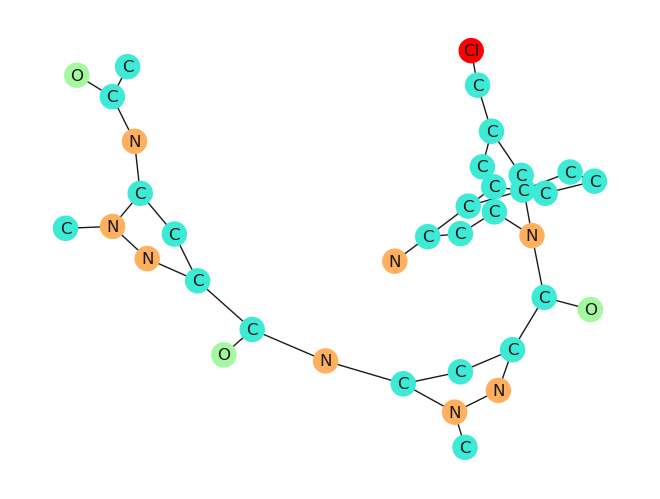

In [16]:
plt.clf()
visualize(training_set[20])

# Pre-Processing

 ## Data Up-Sampling

In [17]:
np.unique(np.array(training_set)[:,2],return_counts=True)
train_df = pd.DataFrame(training_set, columns=['node','edge','label']) # convert train into DataFrame

# print the count of 0,1 in the label column
print(train_df['label'].value_counts())


class_0 = train_df[train_df['label'] == 0] # get all data that belong to negative class (label = 0) 
class_1 = train_df[train_df['label'] == 1] # get all data that belong to possitive class (label = 1) 

class_1 = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)  # resample class_1
upsampled_data = pd.concat([class_1, class_0])  # get upsampled data


# print the count of 0,1 in the label column after data up-sampling
print(upsampled_data["label"].value_counts()) 

0    23806
1     1218
Name: label, dtype: int64
1    23806
0    23806
Name: label, dtype: int64


In [18]:
# convert upsampled_data from DataFram to an array 
data_upsampled = upsampled_data.to_numpy()

In [19]:
training_set, validation_set = train_test_split(data_upsampled, test_size=0.15,)

## Tokenizer

To use the graph representation of a molecule as input to a machine learning model, we need to convert it into a numerical format that the model can process. This requires using a tokenizer, which maps the nodes and links in the graph representation to a set of unique numerical tokens.

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

max_vocab = 500
max_len = 100


# build vocabulary from training set
all_nodes = [s[0] for s in training_set]
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(all_nodes)

## Prepare Batch data

In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
random.seed(0)

def prepare_single_batch(samples):
    # Extracts the list of node labels for each molecule from the samples list 
    sample_nodes = [s[0] for s in samples]
    # Convert each node label in the sample_nodes list to a numeric token. 
    sample_nodes = tokenizer.texts_to_sequences(sample_nodes)
    
    # the pad_sequences function is used to pad the sample_nodes list,to a fixed length. By setting padding='post',
    # the function adds padding zeros to the end of each sequence, so that all sequences have the same length.
    sample_nodes = pad_sequences(sample_nodes, padding='post')
    max_nodes_len = np.shape(sample_nodes)[1]
    edges = [s[1]+i*max_nodes_len for i,s in enumerate(samples)]
    edges = [e for e in edges if len(e) > 0]
    node_to_graph = [[i]*max_nodes_len for i in range(len(samples))]
    
    all_nodes = np.reshape(sample_nodes, -1)
    all_edges = np.concatenate(edges)

    node_to_graph = np.reshape(node_to_graph, -1)
    return {
        'data': all_nodes,
        'edges': all_edges,
        'node2grah': node_to_graph,
    }, np.array([s[2] for s in samples])



def gen_batch(dataset, batch_size=16, repeat=False, shuffle=True):
    while True:
        dataset = list(dataset)
        if shuffle:
            random.shuffle(dataset)
        l = len(dataset)
        for ndx in range(0, l, batch_size):
            batch_samples = dataset[ndx:min(ndx + batch_size, l)]
            yield prepare_single_batch(batch_samples)
        if not repeat:
            break


### showing one batch

In [22]:

for train_batch in gen_batch(training_set, batch_size=4):
    for k,v in train_batch[0].items():
        print(k)
        print(v)
        pass
    print('label', train_batch[1])
    break

data
[ 4  3  3  3  3  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
  0  7  7  4  3  3  3  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  0 14  5  5  5  5  3  3  3  3  3  3  3  3  3  3  1  1  1  1  1  1  1
  1  1  1  4  4  3  3  3  3  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0]
edges
[[ 0  7]
 [ 1  2]
 [ 1  6]
 [ 2  7]
 [ 3  5]
 [ 3  9]
 [ 4  7]
 [ 4 13]
 [ 4 14]
 [ 5  6]
 [ 5  8]
 [ 6 11]
 [ 8 10]
 [ 9 12]
 [10 12]
 [25 38]
 [26 46]
 [27 35]
 [27 44]
 [28 32]
 [28 34]
 [29 33]
 [29 34]
 [30 32]
 [30 39]
 [31 32]
 [31 33]
 [31 36]
 [33 37]
 [34 35]
 [35 41]
 [36 38]
 [37 40]
 [38 40]
 [39 42]
 [39 43]
 [41 45]
 [42 46]
 [43 47]
 [44 45]
 [46 48]
 [47 48]
 [50 51]
 [50 52]
 [50 53]
 [50 54]
 [50 55]
 [50 56]
 [55 65]
 [55 67]
 [56 66]
 [56 68]
 [57 67]
 [57 71]
 [58 68]
 [58 72]
 [59 65]
 [60 66]
 [61 70]
 [61 74]
 [62 69]
 [62 73]
 [63 71]
 [63 73]
 [64 72]
 [64 74]
 [65 69]
 [66 70]
 [69 71]
 [70 72]
 [75 82]
 [75 83]
 [76 81]
 [76 84]
 [77 78]
 [77 82]

# Building DL Model

In [23]:
import math

def train_model(model, training_set, validation_set, batch_size=16, num_epochs=5):
    # calculate steps_per_epoch for training and validation data
    num_batches = math.ceil(len(training_set) / batch_size)
    num_batches_validation = math.ceil(len(validation_set) / batch_size)

    # train the model
    model.fit(
        gen_batch(training_set, batch_size=batch_size, repeat=True),
        steps_per_epoch=num_batches,
        epochs=num_epochs,
        validation_data=gen_batch(validation_set, batch_size=batch_size, repeat=True),
        validation_steps=num_batches_validation
    )

In [24]:
def get_predictions(model, testing_set, batch_size=16):
    y_pred = model.predict(gen_batch(testing_set, batch_size=batch_size, shuffle=False))
    y_pred = np.reshape(y_pred, -1)
    return y_pred

In [25]:

def save_predictions_to_csv(y_pred, file_name):
    submission = pd.DataFrame({'label': y_pred})
    submission.index.name = 'id'
    submission.to_csv(file_name)

## First Trial

**The input of these trial is :**  Training data set without upsampling

**The Model Used is :**
The model uses a **single GNN layer** with dfault hyperparameters. The output of the GNN layer is passed through a function called **segment_mean**, which computes the mean of the node embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.

The output of the segment_mean function is passed through a **dense layer** with a **sigmoid** activation function to produce the final predictions. The model is compiled using the **binary cross-entropy loss** function and the **Adam optimizer**.

In [53]:


data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)

# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 32
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)

print('gnn_out', gnn_out)

# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data=gnn_out,
    segment_ids=node2graph
)
print('mean:', avg)

pred = Dense(1, activation='sigmoid')(avg)
print('pred:', pred)

modelV1 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs=pred
)
modelV1.summary()

gnn_out KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='gnn_6/StatefulPartitionedCall:0', description="created by layer 'gnn_6'")
mean: KerasTensor(type_spec=TensorSpec(shape=(None, 32), dtype=tf.float32, name=None), name='tf.math.segment_mean_3/SegmentMean:0', description="created by layer 'tf.math.segment_mean_3'")
pred: KerasTensor(type_spec=TensorSpec(shape=(None, 1), dtype=tf.float32, name=None), name='dense_6/Sigmoid:0', description="created by layer 'dense_6'")
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None,)]            0           []        

In [54]:
modelV1.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [55]:
train_model(modelV1, training_set, validation_set, batch_size=16, num_epochs=25)
y_pred = get_predictions(modelV1, testing_set)
save_predictions_to_csv(y_pred, 'First_Trial.csv')


Epoch 1/25
1564/1564 [==============================] - 26s 15ms/step - loss: 0.2262 - auc: 0.5049 - val_loss: 1.5427 - val_auc: 0.5924
Epoch 2/25
1564/1564 [==============================] - 24s 15ms/step - loss: 0.1938 - auc: 0.6208 - val_loss: 1.3460 - val_auc: 0.6433
Epoch 3/25
1564/1564 [==============================] - 23s 15ms/step - loss: 0.1902 - auc: 0.6347 - val_loss: 1.6925 - val_auc: 0.6456
Epoch 4/25
1564/1564 [==============================] - 23s 15ms/step - loss: 0.1880 - auc: 0.6591 - val_loss: 1.5467 - val_auc: 0.6749
Epoch 5/25
1564/1564 [==============================] - 23s 15ms/step - loss: 0.1862 - auc: 0.6674 - val_loss: 1.4406 - val_auc: 0.6887
Epoch 6/25
1564/1564 [==============================] - 23s 14ms/step - loss: 0.1849 - auc: 0.6752 - val_loss: 1.5824 - val_auc: 0.6693
Epoch 7/25
1564/1564 [==============================] - 23s 15ms/step - loss: 0.1837 - auc: 0.6762 - val_loss: 1.2808 - val_auc: 0.7015
Epoch 8/25
1564/1564 [==========================

**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 71.32 %</br>
**validatation accuracy (auc)**: 74.20 %</br>
**Testing Accuracy (auc)**: 72.088 %</br></br>

**Comment :** </br>
No overfitting happened here the test score is near to the validation score, maybe the increase in the model complexity of the model will be followed by an increase in performance , or use upsamling for training data set will help in increaseing the performance.</br>
In the next trial we will try to use upsampling data with the same model.

## Second trial

**The input of these trial is :** Upsampling training data set 

**The Model Used is :** Same as the previous model

In [ ]:
train_model(modelV1, training_set, validation_set, batch_size=16, num_epochs=25)
y_pred = get_predictions(modelV1, testing_set)
save_predictions_to_csv(y_pred, 'Second_Trial.csv')


Epoch 1/25
2530/2530 [==============================] - 51s 18ms/step - loss: 0.6394 - auc: 0.6834 - val_loss: 0.6178 - val_auc: 0.7288
Epoch 2/25
2530/2530 [==============================] - 48s 19ms/step - loss: 0.6013 - auc: 0.7390 - val_loss: 0.5833 - val_auc: 0.7596
Epoch 3/25
2530/2530 [==============================] - 49s 19ms/step - loss: 0.5782 - auc: 0.7645 - val_loss: 0.5688 - val_auc: 0.7829
Epoch 4/25
2530/2530 [==============================] - 49s 19ms/step - loss: 0.5619 - auc: 0.7814 - val_loss: 0.5484 - val_auc: 0.7992
Epoch 5/25
2530/2530 [==============================] - 46s 18ms/step - loss: 0.5456 - auc: 0.7980 - val_loss: 0.5217 - val_auc: 0.8230
Epoch 6/25
2530/2530 [==============================] - 46s 18ms/step - loss: 0.5350 - auc: 0.8081 - val_loss: 0.5066 - val_auc: 0.8371
Epoch 7/25
2530/2530 [==============================] - 48s 19ms/step - loss: 0.5246 - auc: 0.8179 - val_loss: 0.5100 - val_auc: 0.8328
Epoch 8/25
2530/2530 [==========================

**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 86.95 %</br>
**validatation accuracy (auc)**: 87.56 %</br>
**Testing Accuracy (auc)**: 80.78 %</br></br>

**Comment:** </br>
As we can see the performance increased when we used upsampling data so we will use upsampling data in the next trials.</br> 
Now we need to use different message passing method to find the best method with our data set.

## Thired Trial

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

The model uses a **single GNN layer** with hyperparameters configured to use a **relational graph convolutional network** (RGCN) message passing method. The output of the GNN layer is passed through a function called **segment_mean**, which computes the mean of the node embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.

The output of the **segment_mean** function is passed through a dense layer with a sigmoid activation function to produce the final predictions. The model is compiled using **the binary cross-entropy loss** function and the **Adam optimizer**.

In [30]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGCN (Relational Graph Convolutional Networks)
params['message_calculation_class'] = 'RGCN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the output layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
modelV3 = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
modelV3.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_6[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 20)           10000       ['input_4[0][0]']            

In [31]:

modelV3.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [32]:
train_model(modelV3, training_set, validation_set, batch_size=16, num_epochs=25)


Epoch 1/25
2530/2530 [==============================] - 42s 15ms/step - loss: 0.6357 - auc: 0.6913 - val_loss: 0.6153 - val_auc: 0.7295
Epoch 2/25
2530/2530 [==============================] - 39s 15ms/step - loss: 0.5960 - auc: 0.7451 - val_loss: 0.5785 - val_auc: 0.7691
Epoch 3/25
2530/2530 [==============================] - 39s 15ms/step - loss: 0.5740 - auc: 0.7687 - val_loss: 0.5545 - val_auc: 0.7846
Epoch 4/25
2530/2530 [==============================] - 39s 15ms/step - loss: 0.5593 - auc: 0.7853 - val_loss: 0.5554 - val_auc: 0.7927
Epoch 5/25
2530/2530 [==============================] - 39s 15ms/step - loss: 0.5457 - auc: 0.7996 - val_loss: 0.5376 - val_auc: 0.8073
Epoch 6/25
2530/2530 [==============================] - 39s 16ms/step - loss: 0.5363 - auc: 0.8084 - val_loss: 0.5303 - val_auc: 0.8134
Epoch 7/25
2530/2530 [==============================] - 39s 16ms/step - loss: 0.5294 - auc: 0.8142 - val_loss: 0.5274 - val_auc: 0.8231
Epoch 8/25
2530/2530 [==========================

NameError: name 'model' is not defined

In [33]:
y_pred = get_predictions(modelV3, testing_set)
save_predictions_to_csv(y_pred, 'Third_Trial.csv')

771/771 [==============================] - 5s 6ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 86.06 %</br>
**validatation accuracy (auc)**: 87.66 %</br>
**Testing Accuracy (auc)**: 81.03 %</br></br>

**Comment :** </br>
when we used relational graph convolutional network (RGCN) message passing method the accuracy slightly increased.</br>
So, we need to use different message passing method or use more complex model.

## Fourth Trial

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

The model uses a **single GNN layer** with hyperparameters configured to use a **relational graph attention network** (RGAT) message passing method. The output of the GNN layer is passed through a function called **segment_mean**, which computes the **mean of the node** embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.

The output of the **segment_mean** function is passed through a dense layer with a **sigmoid** activation function to produce the final predictions. The model is compiled using the **binary cross-entropy loss** function and the **Adam optimizer**.

In [34]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 32
# configures the message passing style to be RGAT (Relational Graph Attention Networks)
params['message_calculation_class'] = 'RGAT'
# configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result.
params["num_heads"] = 4

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
modelV4 = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
modelV4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_1 (TFOpLamb  ()                  0           ['input_9[0][0]']                
 da)                                                                                              
                                                                                                  
 embedding_1 (Embedding)        (None, 20)           10000       ['input_7[0][0]']          

In [35]:

modelV4.compile(
    loss='BinaryCrossentropy',
    metrics=['AUC']
)

In [40]:
train_model(modelV4, training_set, validation_set, batch_size=16, num_epochs=25)
y_pred = get_predictions(modelV4, testing_set)
save_predictions_to_csv(y_pred, 'Fourth_Trial.csv')


Epoch 1/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.6175 - auc: 0.7150 - val_loss: 0.6076 - val_auc: 0.7443
Epoch 2/25
2530/2530 [==============================] - 56s 22ms/step - loss: 0.5843 - auc: 0.7591 - val_loss: 0.5754 - val_auc: 0.7752
Epoch 3/25
2530/2530 [==============================] - 56s 22ms/step - loss: 0.5575 - auc: 0.7888 - val_loss: 0.5552 - val_auc: 0.7978
Epoch 4/25
2530/2530 [==============================] - 54s 21ms/step - loss: 0.5412 - auc: 0.8036 - val_loss: 0.5330 - val_auc: 0.8109
Epoch 5/25
2530/2530 [==============================] - 54s 21ms/step - loss: 0.5259 - auc: 0.8169 - val_loss: 0.5433 - val_auc: 0.8130
Epoch 6/25
2530/2530 [==============================] - 56s 22ms/step - loss: 0.5119 - auc: 0.8279 - val_loss: 0.4991 - val_auc: 0.8393
Epoch 7/25
2530/2530 [==============================] - 56s 22ms/step - loss: 0.4960 - auc: 0.8401 - val_loss: 0.4929 - val_auc: 0.8450
Epoch 8/25
2530/2530 [==========================

**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 90.94 %</br>
**validatation accuracy (auc)**: 91.94 %</br>
**Testing Accuracy (auc)**: 84.614 %</br></br>

**Comment :** </br>
Here, we used RGAT (Relational Graph Attention Networks) as message passing method and it improved the performance.</br></br>
The reason why RGATs may improve the accuracy more than RGCNs in certain cases is that attention mechanisms can help the model focus on the most relevant nodes and edges in the graph, and capture more complex relationships between them. By assigning different weights to different nodes and edges based on their importance, RGATs can improve the accuracy of the model and capture more fine-grained information about the graph.</br>

In contrast, RGCNs use weight-sharing to ensure that the same parameters are used for each edge type. While this can be effective in some cases, it may not be sufficient to capture the full complexity of the graph, especially if there are significant differences between the different types of edges.

## Fifth Trile

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

The model uses a single GNN layer with hyperparameters configured to use a **relational graph attention network** (RGAT) message passing method. The output of the GNN layer is passed through an **attention mechanism**, which applies **a dense layer with a hyperbolic tangent** activation function, followed by a **softmax** activation function, to compute attention weights. These weights are then used to compute a **weighted average** of the node embeddings, which is intended to highlight the most important nodes for the prediction task.

The output of the attention mechanism is passed through a dense layer with a **sigmoid** activation function to produce the final predictions. The model is compiled using the Adam optimizer and binary cross-entropy loss function, and the accuracy metric is used to evaluate the model performance. 

In [26]:

data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)
params = GNN.get_default_hyperparameters()
params['hidden_dim'] = 32
params['num_heads'] = 4
params['dropout_rate'] = 0.2
params['message_calculation_class'] = 'RGAT'
gnn_layer1 = GNN(params)(gnn_input)

attn = layers.Dense(1, activation="tanh")(gnn_layer1)
attn = layers.Flatten()(attn)
attn = layers.Activation("softmax")(attn)
attn = layers.Dense(32)(attn)
# attn = layers.Reshape((32))(attn)  # Add a Reshape layer to convert attn to (None, 1, 20)
# attn = layers.Permute([2, 1])(attn)
attn_out = layers.Multiply()([gnn_layer1, attn])
attn_out = segment_mean(data =attn_out, segment_ids = node2graph) 

output = layers.Dense(1, activation="sigmoid")(attn_out)
labels = keras.Input(batch_shape=(None,))
labels = layers.Reshape((1,))(labels)  # Reshape labels to have shape (None, 1)


modelV5 = Model(inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    }, outputs=output)
modelV5.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
modelV5.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max (TFOpLambda  ()                  0           ['input_3[0][0]']                
 )                                                                                                
                                                                                                  
 embedding (Embedding)          (None, 20)           10000       ['input_1[0][0]']            

In [27]:
train_model(modelV5, training_set, validation_set, batch_size=16, num_epochs=25)

Epoch 1/25
2530/2530 [==============================] - 63s 22ms/step - loss: 0.6230 - accuracy: 0.6556 - val_loss: 0.5911 - val_accuracy: 0.7067
Epoch 2/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5814 - accuracy: 0.7066 - val_loss: 0.5739 - val_accuracy: 0.7153
Epoch 3/25
2530/2530 [==============================] - 57s 22ms/step - loss: 0.5547 - accuracy: 0.7273 - val_loss: 0.5356 - val_accuracy: 0.7425
Epoch 4/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5329 - accuracy: 0.7405 - val_loss: 0.5165 - val_accuracy: 0.7546
Epoch 5/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5200 - accuracy: 0.7487 - val_loss: 0.5032 - val_accuracy: 0.7572
Epoch 6/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.5055 - accuracy: 0.7586 - val_loss: 0.4857 - val_accuracy: 0.7740
Epoch 7/25
2530/2530 [==============================] - 55s 22ms/step - loss: 0.4922 - accuracy: 0.7657 - val_loss: 0.4762 -

In [28]:
y_pred = get_predictions(modelV5, testing_set)

771/771 [==============================] - 6s 8ms/step


In [29]:
save_predictions_to_csv(y_pred, 'Fifth_Trial.csv')


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 84.25 %</br>
**validatation accuracy (auc)**: 85.44 %</br>
**Testing Accuracy (auc)**: 84.617 %</br></br>

**Comment :** </br>
When we used more complex model the performance didn't improve that maybe our data is small so more complex model will not add more benfit.

## Sixth Trile

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

**The model uses two GNN layers**, each with a different set of hyperparameters, to learn representations of the molecular graphs. The outputs of the GNN layers are then pooled **using mean pooling**, and **concatenated together**. The resulting pooled outputs are then passed through a **dropout layer** for regularization, and finally through **a dense layer** with a sigmoid activation function to produce the final predictions.

**The model is compiled** using the AdamW optimizer and binary cross-entropy loss function, and the accuracy metric is used to evaluate the model performance. 

In [30]:

# from tf2_gnn.utils.general import get_aggregate_method_from_str


data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# Define the GNN layers
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 8
params["dropout_rate"] = 0.2
params["message_calculation_class"] = "RGCN"
gnn_layer1 = GNN(params)
gnn_out1 = gnn_layer1(gnn_input)

params["hidden_dim"] = 32
params["num_heads"] = 4
params["dropout_rate"] = 0.1
params["message_calculation_class"] = "RGAT"
gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

# Apply mean pooling to the outputs of the GNN layers
pool_out1 = tf.math.unsorted_segment_mean(gnn_out1, node2graph, num_graph)
pool_out2 = tf.math.unsorted_segment_mean(gnn_out2, node2graph, num_graph)

# Concatenate the pooled outputs
pool_out = layers.concatenate([pool_out1, pool_out2])

# Add dropout regularization
dropout = layers.Dropout(0.3)(pool_out)

# Define the output layer of the model
pred = layers.Dense(1, activation="sigmoid")(dropout)

# Create the model
modelV6 = Model(inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },  outputs=pred)

# Use AdamW optimizer and binary cross-entropy loss
opt = Adam(learning_rate=0.001)
modelV6.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

modelV6.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_4 (TFOpLamb  ()                  0           ['input_15[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_13[0][0]']         

In [31]:
train_model(modelV6, training_set, validation_set, batch_size=16, num_epochs=25)


Epoch 1/25
2530/2530 [==============================] - 97s 34ms/step - loss: 0.6077 - accuracy: 0.6742 - val_loss: 0.5663 - val_accuracy: 0.7099
Epoch 2/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.5520 - accuracy: 0.7282 - val_loss: 0.5352 - val_accuracy: 0.7375
Epoch 3/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.5338 - accuracy: 0.7363 - val_loss: 0.5204 - val_accuracy: 0.7405
Epoch 4/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.5153 - accuracy: 0.7447 - val_loss: 0.5050 - val_accuracy: 0.7482
Epoch 5/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.5013 - accuracy: 0.7569 - val_loss: 0.4925 - val_accuracy: 0.7676
Epoch 6/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.4865 - accuracy: 0.7702 - val_loss: 0.4787 - val_accuracy: 0.7684
Epoch 7/25
2530/2530 [==============================] - 86s 34ms/step - loss: 0.4783 - accuracy: 0.7744 - val_loss: 0.4806 -

In [32]:
y_pred = get_predictions(modelV6, testing_set)
save_predictions_to_csv(y_pred, 'Sixth_Trial.csv')

771/771 [==============================] - 9s 10ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 87.85 %</br>
**validatation accuracy (auc)**: 88.13 %</br>
**Testing Accuracy (auc)**: 83.11 %</br></br>

**Comment :** </br>
Here we tried to use more complex model as we used two layers with two different  message passing methods (RGAT,RGCN)But the accuracy decreased then trial number foure</br> 
The reasone for that may be because of: </br>Interference between message passing methods: If the RGAT and RGCN message passing methods are not complementary or compatible, they may interfere with each other and degrade the performance of the model. It's possible that the two-layer model did not effectively combine the information from the two

# Seventh Trile

**The input of these trial is :**  Training data set without upsampling

**The Model Used is :**
The model uses a **single GNN layer** with hyperparameters configured to use a **Gated Graph Neural Networks** (GGNN) message passing method. The output of the GNN layer is passed through a function called **segment_mean**, which computes the mean of the node embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.

The output of the segment_mean function is passed through a **dense layer** with a **sigmoid** activation function to produce the final predictions. The model is compiled using the **binary cross-entropy loss** function and the **Adam optimizer**.

In [96]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features=embeded,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph, 
    num_graphs=num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the message passing style to be GGNN (Gated Graph Neural Networks)
params['message_calculation_class'] = 'GGNN'

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
modelV7 = Model(
    inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
modelV7.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
modelV7.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_108 (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 input_106 (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_54 (TFOpLam  ()                  0           ['input_108[0][0]']              
 bda)                                                                                             
                                                                                                  
 embedding_34 (Embedding)       (None, 20)           10000       ['input_106[0][0]']       

In [97]:
train_model(modelV7, training_set, validation_set, batch_size=16, num_epochs=25)

Epoch 1/25
2530/2530 [==============================] - 109s 41ms/step - loss: 0.5944 - accuracy: 0.6824 - val_loss: 0.5528 - val_accuracy: 0.7267
Epoch 2/25
2530/2530 [==============================] - 104s 41ms/step - loss: 0.5327 - accuracy: 0.7410 - val_loss: 0.5065 - val_accuracy: 0.7607
Epoch 3/25
1449/2530 [================>.............] - ETA: 41s - loss: 0.4857 - accuracy: 0.7738

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2530/2530 [==============================] - 105s 41ms/step - loss: 0.4296 - accuracy: 0.8062 - val_loss: 0.4117 - val_accuracy: 0.8247
Epoch 5/25
2530/2530 [==============================] - 104s 41ms/step - loss: 0.3900 - accuracy: 0.8280 - val_loss: 0.3898 - val_accuracy: 0.8306
Epoch 6/25
1773/2530 [====================>.........] - ETA: 29s - loss: 0.3642 - accuracy: 0.8409

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2530/2530 [==============================] - 102s 40ms/step - loss: 0.3320 - accuracy: 0.8595 - val_loss: 0.3226 - val_accuracy: 0.8596
Epoch 8/25
2530/2530 [==============================] - 103s 41ms/step - loss: 0.3037 - accuracy: 0.8722 - val_loss: 0.3130 - val_accuracy: 0.8726
Epoch 9/25
2471/2530 [============================>.] - ETA: 2s - loss: 0.2778 - accuracy: 0.8865

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2530/2530 [==============================] - 102s 40ms/step - loss: 0.3008 - accuracy: 0.8744 - val_loss: 0.2470 - val_accuracy: 0.9053
Epoch 11/25
2530/2530 [==============================] - 102s 41ms/step - loss: 0.2435 - accuracy: 0.9035 - val_loss: 0.2430 - val_accuracy: 0.9034
Epoch 12/25
2530/2530 [==============================] - 107s 42ms/step - loss: 0.3644 - accuracy: 0.8376 - val_loss: 0.3504 - val_accuracy: 0.8437
Epoch 17/25
2530/2530 [==============================] - 102s 40ms/step - loss: 0.3136 - accuracy: 0.8679 - val_loss: 0.2847 - val_accuracy: 0.8906
Epoch 18/25
2530/2530 [==============================] - 104s 41ms/step - loss: 0.2611 - accuracy: 0.8931 - val_loss: 0.2781 - val_accuracy: 0.8944
Epoch 19/25
2530/2530 [==============================] - 104s 41ms/step - loss: 0.2426 - accuracy: 0.9029 - val_loss: 0.2537 - val_accuracy: 0.9048
Epoch 20/25
2530/2530 [==============================] - 107s 42ms/step - loss: 0.2187 - accuracy: 0.9152 - val_loss: 0.2203

In [98]:
y_pred = get_predictions(modelV7, testing_set)
save_predictions_to_csv(y_pred, 'Seventh_Trial.csv')

771/771 [==============================] - 11s 13ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 94.12 %</br>
**validatation accuracy (auc)**: 94.55 %</br>
**Testing Accuracy (auc)**: 85.64 %</br></br>

**Comment :** </br>
When we tried to use Gated Graph Neural Networks (GGNN) message passing method it improve test accuracy more than RGCN,RGAT methods.</br>

The reason why GGNNs may improve the accuracy more than RGCNs or RGATs in certain cases is that they can capture more complex temporal dependencies between the nodes in the graph. Unlike RGCNs and RGATs, which perform message passing in a fixed order and do not consider the temporal order of the nodes, GGNNs use recurrent units to update the node representations in a way that depends on the previous states of the nodes. This allows GGNNs to capture more fine-grained information about the graph and improve the accuracy of the model.

# Eighth trial

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

**The model uses two GNN layers**, with same set of hyperparameters configured to use (**GGNN**) message passing method, to learn representations of the molecular graphs. The outputs of the GNN layers are then pooled **using mean pooling**, and **concatenated together**. The resulting pooled outputs are then passed through a **dropout layer** for regularization, and finally through **a dense layer** with a sigmoid activation function to produce the final predictions.

**The model is compiled** using the AdamW optimizer and binary cross-entropy loss function, and the accuracy metric is used to evaluate the model performance. 

In [99]:

# from tf2_gnn.utils.general import get_aggregate_method_from_str


data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# Define the GNN layers
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 8
params["dropout_rate"] = 0.2
params["message_calculation_class"] = "GGNN"
gnn_layer1 = GNN(params)
gnn_out1 = gnn_layer1(gnn_input)

params["hidden_dim"] = 32
params["num_heads"] = 4
params["dropout_rate"] = 0.1
params["message_calculation_class"] = "GGNN"
gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

# Apply mean pooling to the outputs of the GNN layers
pool_out1 = tf.math.unsorted_segment_mean(gnn_out1, node2graph, num_graph)
pool_out2 = tf.math.unsorted_segment_mean(gnn_out2, node2graph, num_graph)

# Concatenate the pooled outputs
pool_out = layers.concatenate([pool_out1, pool_out2])

# Add dropout regularization
dropout = layers.Dropout(0.3)(pool_out)

# Define the output layer of the model
pred = layers.Dense(1, activation="sigmoid")(dropout)

# Create the model
modelV8 = Model(inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },  outputs=pred)

# Use AdamW optimizer and binary cross-entropy loss
opt = Adam(learning_rate=0.001)
modelV8.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

modelV8.summary()


Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_111 (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 input_109 (InputLayer)         [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_55 (TFOpLam  ()                  0           ['input_111[0][0]']              
 bda)                                                                                             
                                                                                                  
 embedding_35 (Embedding)       (None, 20)           10000       ['input_109[0][0]']       

In [103]:
train_model(modelV8, training_set, validation_set, batch_size=16, num_epochs=5)

Epoch 1/5
2530/2530 [==============================] - 127s 50ms/step - loss: 0.2444 - accuracy: 0.9016 - val_loss: 0.2670 - val_accuracy: 0.9010
Epoch 2/5
2530/2530 [==============================] - 127s 50ms/step - loss: 0.2644 - accuracy: 0.8937 - val_loss: 0.2429 - val_accuracy: 0.9097
Epoch 3/5
2530/2530 [==============================] - 125s 50ms/step - loss: 0.2462 - accuracy: 0.9011 - val_loss: 0.2408 - val_accuracy: 0.9115
Epoch 4/5
2530/2530 [==============================] - 124s 49ms/step - loss: 0.2292 - accuracy: 0.9111 - val_loss: 0.2524 - val_accuracy: 0.9147
Epoch 5/5
2530/2530 [==============================] - 126s 50ms/step - loss: 0.2258 - accuracy: 0.9126 - val_loss: 0.2532 - val_accuracy: 0.9142


In [104]:
y_pred = get_predictions(modelV8, testing_set)
save_predictions_to_csv(y_pred, 'Eighth_Trial.csv')

771/771 [==============================] - 13s 16ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 91.26 %</br>
**validatation accuracy (auc)**: 91.42 %</br>
**Testing Accuracy (auc)**: 85.67 %</br></br>

**Comment :** </br>
Here we tried to use more complex model as we used two layers with same  message passing methods (GGNN) But the accuracy didn't improve then the the simple model</br> 


# Ninth Trial 

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

**The model uses three GNN layers**, with same set of hyperparameters configured to use (**RGAT**) message passing method, to learn representations of the molecular graphs. There are **dropout layer**  detween each layer for regularization. The output of the GNN layers is passed through a function called **segment_mean**, which computes the mean of the node embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.
**The model is compiled** using the AdamW optimizer and binary cross-entropy loss function, and the accuracy metric is used to evaluate the model performance. 

In [30]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


params["hidden_dim"] = 64
params["num_heads"] = 4
params["dropout_rate"] = 0.2
params["message_calculation_class"] = "GGNN"

gnn_layer1 = GNN(params)
gnn_out1 = Dropout(0.2)(gnn_layer1(gnn_input))

gnn_layer2 = GNN(params)
gnn_out2 = Dropout(0.2)(gnn_layer2(GNNInput(
    node_features=gnn_out1,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=tf.reduce_max(node2graph) + 1,
)))

gnn_layer3 = GNN(params)
gnn_out3 = Dropout(0.2)(gnn_layer3(GNNInput(
    node_features=gnn_out2,
    adjacency_lists=(edge,),
    node_to_graph_map=node2graph,
    num_graphs=tf.reduce_max(node2graph) + 1,
)))

avg = segment_mean(
    data=gnn_out3,
    segment_ids=node2graph
)

pred = Dense(1, activation="sigmoid")(avg)

modelV9 = Model(inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    }, outputs=pred)
modelV9.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [31]:
train_model(modelV9, training_set, validation_set, batch_size=16, num_epochs=25)

Epoch 1/25
2530/2530 [==============================] - 289s 109ms/step - loss: 0.6314 - accuracy: 0.6453 - val_loss: 0.6328 - val_accuracy: 0.6409
Epoch 2/25
2530/2530 [==============================] - 275s 109ms/step - loss: 0.6205 - accuracy: 0.6576 - val_loss: 0.6214 - val_accuracy: 0.6568
Epoch 3/25
2530/2530 [==============================] - 275s 109ms/step - loss: 0.6016 - accuracy: 0.6768 - val_loss: 0.5993 - val_accuracy: 0.6838
Epoch 4/25
2530/2530 [==============================] - 273s 108ms/step - loss: 0.5840 - accuracy: 0.6933 - val_loss: 0.5819 - val_accuracy: 0.6932
Epoch 5/25
2530/2530 [==============================] - 278s 110ms/step - loss: 0.5772 - accuracy: 0.6978 - val_loss: 0.6033 - val_accuracy: 0.6823
Epoch 6/25
2530/2530 [==============================] - 271s 107ms/step - loss: 0.5785 - accuracy: 0.6988 - val_loss: 0.5579 - val_accuracy: 0.7173
Epoch 7/25
2530/2530 [==============================] - 272s 108ms/step - loss: 0.5570 - accuracy: 0.7187 - val_

In [32]:
y_pred = get_predictions(modelV9, testing_set)
save_predictions_to_csv(y_pred, 'Ninth_Trial.csv')

771/771 [==============================] - 24s 29ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 84.27 %</br>
**validatation accuracy (auc)**: 84.19 %</br>
**Testing Accuracy (auc)**: 77.17 %</br></br>

**Comment :** </br>
Here we tried more complex model as we used three layer from GNN layer.</br> 
But the accuracy decreased ten the simple model.</br>

## Tenth Trial

**The input of these trial is :**  Training data set without upsampling

**The Model Used is :**
The model uses a **single GNN layer** with hyperparameters configured to use a **Rational graph convolutional network** (RGCN) message passing method. The output of the GNN layer is passed through a function called **segment_mean**, which computes the mean of the node embeddings for each graph in the batch. This is intended to summarize the information from the nodes into a single vector per graph, which can be used for the prediction task.

The output of the segment_mean function is passed through a **dense layer** with a **sigmoid** activation function to produce the final predictions. The model is compiled using the **binary cross-entropy loss** function and the **Adam optimizer**.

In [77]:
data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# configure the hyperparameters of GNN layers
# https://github.com/microsoft/tf2-gnn/blob/master/tf2_gnn/layers/gnn.py
# 
# frist load the defualt hyperparameters
params = GNN.get_default_hyperparameters()
# sets the size of the output of all message passing layers
params["hidden_dim"] = 64
# configures the message passing style to be RGCN
params['message_calculation_class'] = 'RGCN'
# configures the number of parallel (independent) weighted sums that are computed, whose results are concatenated to obtain the final result.
params["num_heads"] = 4

# Implements a deep Graph Neural Network
gnn_layer = GNN(params)
gnn_out = gnn_layer(gnn_input)



# Computes the mean along segments of a tensor
# https://www.tensorflow.org/api_docs/python/tf/math/segment_mean
avg = segment_mean(
    data = gnn_out,
    segment_ids = node2graph
)

# Define the out put layer of the model
pred = Dense(1, activation='sigmoid')(avg)


# Creating the model
modelV10 = Model(
    inputs = {
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },
    outputs = pred
)
modelV10.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
modelV10.summary()

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_81 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_79 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_44 (TFOpLam  ()                  0           ['input_81[0][0]']               
 bda)                                                                                             
                                                                                                  
 embedding_25 (Embedding)       (None, 20)           10000       ['input_79[0][0]']        

In [78]:
train_model(modelV10, training_set, validation_set, batch_size=16, num_epochs=20)

Epoch 1/20
2530/2530 [==============================] - 70s 26ms/step - loss: 0.6142 - accuracy: 0.6621 - val_loss: 0.5911 - val_accuracy: 0.6894
Epoch 2/20
2530/2530 [==============================] - 66s 26ms/step - loss: 0.5845 - accuracy: 0.6957 - val_loss: 0.5743 - val_accuracy: 0.7012
Epoch 3/20
2530/2530 [==============================] - 67s 27ms/step - loss: 0.5599 - accuracy: 0.7197 - val_loss: 0.5535 - val_accuracy: 0.7174
Epoch 4/20
2530/2530 [==============================] - 66s 26ms/step - loss: 0.5319 - accuracy: 0.7401 - val_loss: 0.5182 - val_accuracy: 0.7533
Epoch 5/20
2530/2530 [==============================] - 66s 26ms/step - loss: 0.5103 - accuracy: 0.7578 - val_loss: 0.5005 - val_accuracy: 0.7604
Epoch 6/20
2530/2530 [==============================] - 65s 26ms/step - loss: 0.4991 - accuracy: 0.7606 - val_loss: 0.4949 - val_accuracy: 0.7595
Epoch 7/20
2530/2530 [==============================] - 66s 26ms/step - loss: 0.4769 - accuracy: 0.7745 - val_loss: 0.4746 -

In [83]:
y_pred = get_predictions(modelV10, testing_set)
save_predictions_to_csv(y_pred, 'Tenth_Trial.csv')

771/771 [==============================] - 7s 8ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 87.07 %</br>
**validatation accuracy (auc)**: 87.13 %</br>
**Testing Accuracy (auc)**: 50 %</br></br>

**Comment :** </br>

In previous trial we try to use the same model with the same massig passing method but here we will try to change in different hyperparameter as we see we will try to use 64 hidden_dim, and 4 num_heads. 
But the accuracy become so bad that may because of: </br>Lack of convergence: Changing the hyperparameters can affect the convergence of the model during training. If the model doesn't converge to a good solution, it may perform poorly on the test data.

# Elventh Trial

**The input of these trial is :** Upsampling training data set 

**The Model Used is :**

**The model uses two GNN layers**, each with a different set of hyperparameters, to learn representations of the molecular graphs. The outputs of the GNN layers are then pooled **using mean pooling**, and **concatenated together**. The resulting pooled outputs are then passed through a **dropout layer** for regularization, and finally through **a dense layer** with a sigmoid activation function to produce the final predictions.

**The model is compiled** using the AdamW optimizer and binary cross-entropy loss function, and the accuracy metric is used to evaluate the model performance. 

In [37]:

# from tf2_gnn.utils.general import get_aggregate_method_from_str


data = keras.Input(batch_shape=(None,))

# the first dim is different to the previous one. it is the total number of edges in this batch
edge = keras.Input(batch_shape=(None, 2), dtype=tf.int32)
node2graph = keras.Input(batch_shape=(None,), dtype=tf.int32)
embeded = Embedding(tokenizer.num_words, 20)(data)

# number of graphs (number of samples)
num_graph = tf.reduce_max(node2graph)+1

# declare the GNNInput that take the features of node, the edge, the created list 'node2graph', and number of graphs (number of samples)
gnn_input = GNNInput(
    node_features = embeded,
    adjacency_lists = (edge,),
    node_to_graph_map = node2graph, 
    num_graphs = num_graph,
)


# Define the GNN layers
params = GNN.get_default_hyperparameters()
params["hidden_dim"] = 64
params["num_heads"] = 8
params["dropout_rate"] = 0.1
params["message_calculation_class"] = "RGCN"
gnn_layer1 = GNN(params)
gnn_out1 = gnn_layer1(gnn_input)

params["hidden_dim"] = 32
params["num_heads"] = 4
params["dropout_rate"] = 0.1
params["message_calculation_class"] = "GGNN"
gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

gnn_layer2 = GNN(params)
gnn_out2 = gnn_layer2(gnn_input)

# Apply mean pooling to the outputs of the GNN layers
pool_out1 = tf.math.unsorted_segment_mean(gnn_out1, node2graph, num_graph)
pool_out2 = tf.math.unsorted_segment_mean(gnn_out2, node2graph, num_graph)

# Concatenate the pooled outputs
pool_out = layers.concatenate([pool_out1, pool_out2])

# Add dropout regularization
dropout = layers.Dropout(0.3)(pool_out)

# Define the output layer of the model
pred = layers.Dense(1, activation="sigmoid")(dropout)

# Create the model
modelV11 = Model(inputs={
        'data': data,
        'edges': edge,
        'node2grah': node2graph,
    },  outputs=pred)

# Use AdamW optimizer and binary cross-entropy loss
opt = Adam(learning_rate=0.001)
modelV11.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])

modelV11.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 tf.math.reduce_max_5 (TFOpLamb  ()                  0           ['input_13[0][0]']               
 da)                                                                                              
                                                                                                  
 embedding_3 (Embedding)        (None, 20)           10000       ['input_11[0][0]']         

In [38]:
train_model(modelV11, training_set, validation_set, batch_size=16, num_epochs=20)

Epoch 1/20
2530/2530 [==============================] - 95s 34ms/step - loss: 0.6227 - accuracy: 0.6569 - val_loss: 0.6194 - val_accuracy: 0.6448
Epoch 2/20
2530/2530 [==============================] - 86s 34ms/step - loss: 0.5934 - accuracy: 0.6926 - val_loss: 0.5714 - val_accuracy: 0.7158
Epoch 3/20
2530/2530 [==============================] - 85s 33ms/step - loss: 0.5507 - accuracy: 0.7260 - val_loss: 0.5231 - val_accuracy: 0.7456
Epoch 4/20
2530/2530 [==============================] - 84s 33ms/step - loss: 0.5046 - accuracy: 0.7634 - val_loss: 0.4882 - val_accuracy: 0.7695
Epoch 5/20
2530/2530 [==============================] - 84s 33ms/step - loss: 0.4664 - accuracy: 0.7861 - val_loss: 0.4552 - val_accuracy: 0.7847
Epoch 6/20
2530/2530 [==============================] - 84s 33ms/step - loss: 0.4353 - accuracy: 0.8022 - val_loss: 0.4124 - val_accuracy: 0.8124
Epoch 7/20
2530/2530 [==============================] - 84s 33ms/step - loss: 0.4145 - accuracy: 0.8133 - val_loss: 0.3941 -

In [36]:
y_pred = get_predictions(modelV11, testing_set)
save_predictions_to_csv(y_pred, 'Eleventh_Trial.csv')

771/771 [==============================] - 12s 14ms/step


**Result of the previous trial is :**  </br>
**Training accuracy (auc)**: 89.43 %</br>
**validatation accuracy (auc)**: 90.02 %</br>
**Testing Accuracy (auc)**: 87.053 %</br></br>

**Comment :** </br>  
So these model get the best accuracy until now.

# Best Model :
From above we can see that the trial number eleven has the best scor in the test data set 
So we can achive our bst model by using : 
1. up sampling for the learning data set 
2. two GNN layer one of them use RGCN as  message calculation class ,and other GGNN
3. mean pooling, and concatenated two layer 
4. dropout layer (0.3)
5. finally, dense layer with sigmoid activation function 

# Question

**🌈Based on the provided template, describe the format of the input file (sdf file).**

The Structure Data File (SDF) format is a text-based file format for storing molecular structures and associated data. It was originally developed by Molecular Design Limited (MDL) and is now widely used in the chemistry and drug discovery fields.

The SDF format consists of a series of records, each of which represents a single molecular structure. Each record has a fixed format, consisting of one or more header lines followed by a series of data lines. The header lines describe the structure and associated data, while the data lines represent the atoms and bonds in the molecule.

**🌈What are the input tensors to the neural network model (their meaning, not just symbol)? What is each of their dims and their meaning (e.g. batch_size)?**

The input tensors to the neural network model are:

**data tensor**: This tensor contains the node features for all the nodes in the input graph. It has a shape of **(batch_size, num_nodes)**, where batch_size is the number of graphs in the batch, and num_nodes is the maximum number of nodes in any graph in the batch. Each element in the tensor represents the feature value for a particular node in a particular graph.

**edge tensor**: This tensor contains the edge connections between the nodes in the input graph. It is a **two-dimensional tensor** of shape **(num_edges, 2)**, where num_edges is the total number of edges in the batch. The first column represents the source node index, and the second column represents the destination node index.

**node2graph tensor**: This tensor indicates which graph each node belongs to. It is a **one-dimensional** tensor of shape **(num_nodes,)**, where num_nodes is the total number of nodes in the batch. Each element in the tensor represents the graph ID of the corresponding node in the data tensor.

**🌈For each dim of gnn_out, what does it symbolize? For each dim of avg, what does it symbolize?**

**gnn_out**: This tensor represents the output of the GNN layers in the neural network model. It has a shape of (batch_size, num_nodes, hidden_dim), where:</br>

*    batch_size is the number of graphs in the batch.</br>
*    num_nodes is the maximum number of nodes in any graph in the batch.</br>
*    hidden_dim is the number of hidden units in the GNN layers.</br>
 Each element of gnn_out represents the hidden state of a particular node in a particular graph, after processing the input graph through the GNN layers.</br></br>

**avg**: This tensor represents the output of the global pooling operation on the gnn_out tensor. It has a shape of (batch_size, hidden_dim), where:

*        batch_size is the number of graphs in the batch.</br>
*        hidden_dim is the number of hidden units in the GNN layers.</br>
 Each element of avg represents the average hidden state across all nodes in a particular graph, after processing the input graph through the GNN layers.

**🌈What is the difference between segment_mean and tf.reduce_mean? For each dim of pred, what does it symbolize?**

**segment_mean** and **tf.reduce_mean** are two different functions in TensorFlow that compute the mean across different segments of a tensor.

**tf.reduce_mean** computes the mean across all elements of a tensor, while **segment_mean** computes the mean across segments of a tensor, where the segments are defined by another tensor of the same shape.

**For example,** if you have a tensor x of shape (batch_size, num_nodes, hidden_dim) and a tensor segment_ids of shape (batch_size, num_nodes), where each element of segment_ids represents the ID of the segment that the corresponding element of x belongs to, you can compute the segment means of x using segment_mean(x, segment_ids).

**As for the dimensions of pred,** it depends on the task and the specific neural network model being used. In general, the dimensions of pred represent the output of the model after processing the input data, and can vary depending on the architecture of the model and the type of output being predicted.

**However,** in the case of binary classification, pred typically has a shape of (batch_size, 1), where batch_size is the number of samples in the input batch, and each element represents the predicted probability that the corresponding sample belongs to the positive class.

**🌈What is the motivation/theory/idea to use multiple gcn layers comparing to just one? How many layers were used in the template?**

The motivation behind using multiple graph convolutional network (GCN) layers in a neural network model is to enable the model to capture increasingly complex and abstract features of the input graph data. Each GCN layer learns to aggregate information from a node's local neighborhood, and the output of one GCN layer can be fed as input to the next GCN layer, allowing the model to learn more complex graph-level features that depend on larger neighborhoods of nodes.

By stacking multiple GCN layers, the model can learn increasingly abstract representations of the input graph, allowing it to better distinguish between different types of graphs or perform more complex tasks on the graph data.

The number of GCN layers used in a neural network model can vary depending on the specific application and the complexity of the input graph data. In the template provided, the model has two GCN layers, but this number can be increased or decreased depending on the needs of the specific application.